 <div style="text-align:center;">
  # <span style="color:green; font-size:larger; font-weight:bold;">Vérification de la loi d'Okun dans plusieurs pays du monde</span><br><br>
  <span style="font-weight:bold;">Présenté par:</span><br>
  <span>NOUBOUSSI GNINTEDEM LUCIE MARIMAR</span><br>
  <span>YOUSRA JEDDOUB</span> <br>
  <span>AMINA MANSEUR</span>
</div>


<span style="color:green; font-size:larger; font-weight:bold;">INTRODUCTION</span>

FAIRE UNE INTRODCUTION

# <span style="color:green">I- Importation et installation des packages</span>

In [4]:
import monmodule.declarations as d
import monmodule.declarations as d

In [ ]:
d.

# <span style="color:green; ">II- Construction de la base de données</span>

il faut faire une explication de toutes lés étapes que nous allons faire pour constituer notre base 

## <span style="color:green; text-align:center;">II-1 Importation de la base GemDataEXTR.Zip via son url de téléchargement</span>

In [5]:
url = "https://datacatalogfiles.worldbank.org/ddh-published/0037798/DR0092042/GemDataEXTR.zip?"
d.load(url,"GemDataEXTR.zip")

Téléchargement de base GemDataEXTR.zip réussi.


In [6]:
# Choix des fichiers à extraire

nom_fichiers=[ ('Unemployment Rate, seas. adj..xlsx', 'monthly'),
              ('GDP Deflator at Market Prices, LCU.xlsx', 'quarterly')
]

# Extraction des bases dans la mémoire: chomage et PIB déflaté
df_Unemployement, df_GDP= [d.extraire_fichier_zip('GemDataEXTR.zip', nom_fichier, nom_feuille)
                           for nom_fichier, nom_feuille in nom_fichiers]

L'extraction des données sur le taux de chômage et le PIB déflaté par pays est désormais complète. <br>
Dans la prochaine étape, nous procéderons à une exploration rapide de ces données et les fusionnerons pour une analyse plus approfondie.


### <span style="color:green; text-align:center;">II-1-1 Préparation des bases avant fusion</span>

#### <span style="color:green; text-align:center;">II-1-1-1 Base taux de chômage</span>

In [8]:
df_Unemployement.head()

,Advanced Economies,Argentina,Australia,Austria,Belgium,Bulgaria,Bahrain,Belarus,Brazil,Canada,...,Thailand,Tunisia,Turkey,"Taiwan, China",Uruguay,United States,"Venezuela, RB",Viet Nam,World (WBG members),South Africa
Year,,,,,,,,,,,,,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-12-01,8.305220,NaN,10.66106,6.869156,9.450078,16.08,NaN,NaN,NaN,11.4,...,NaN,NaN,NaN,1.3,NaN,6.5,NaN,NaN,NaN,NaN
1994-01-01,8.328236,NaN,10.58005,6.672157,9.518617,15.86,NaN,NaN,NaN,11.4,...,NaN,NaN,NaN,1.4,NaN,6.6,NaN,NaN,NaN,NaN
1994-02-01,8.328561,NaN,10.36909,6.637267,9.631846,15.67,NaN,NaN,NaN,11.1,...,NaN,NaN,NaN,1.7,NaN,6.6,NaN,NaN,NaN,NaN
1994-03-01,8.265035,NaN,10.33146,6.425844,9.716527,15.49,NaN,NaN,NaN,10.6,...,NaN,NaN,NaN,1.6,NaN,6.5,NaN,NaN,NaN,NaN


In [9]:
#type des données
df_Unemployement.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, NaT to 2023-01-01
Data columns (total 79 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Advanced Economies                                312 non-null    float64
 1   Argentina                                         258 non-null    float64
 2   Australia                                         359 non-null    float64
 3   Austria                                           359 non-null    float64
 4   Belgium                                           358 non-null    float64
 5   Bulgaria                                          359 non-null    float64
 6   Bahrain                                           180 non-null    float64
 7   Belarus                                           81 non-null     float64
 8   Brazil                                            139 non-null    float64
 9   Canada   


Le type de chaque variable est approprié et correspond aux types attendus.

##### Detections des doublons

In [10]:
#vérification des doublons
print("Nombre total de doublons dans df_Unemployement :", 
      df_Unemployement[df_Unemployement.duplicated()].shape[0])

Nombre total de doublons dans df_Unemployement : 0


##### Corrections des noms des pays

In [11]:
# Appliquer la correction sur chaque colonne du DataFrame
df_Unemployement.columns=d.correct_country_name(df_Unemployement.columns)
# listes des pays détecter
pays=d.detect_country_name(df_Unemployement.columns)
# base avec colonnes corrigées
df_Unemployement=df_Unemployement[[pays]]

SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')


KeyError: "None of [Index([('Argentina', 'Australia', 'Austria', 'Belgium', 'Bulgaria', 'Bahrain', 'Belarus', 'Brazil', 'Canada', 'Switzerland', 'Chile', 'Colombia', 'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom', 'Greece', 'Croatia', 'Hungary', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Japan', 'Sri Lanka', 'Lithuania', 'Luxembourg', 'Latvia', 'Morocco', 'Mexico', 'North Macedonia', 'Malta', 'Netherlands', 'Norway', 'New Zealand', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russian Federation', 'Saudi Arabia', 'Singapore', 'Slovakia', 'Slovenia', 'Sweden', 'Thailand', 'Tunisia', 'Uruguay', 'United States', 'Viet Nam', 'South Africa')], dtype='object')] are in the [columns]"

##### Detections des valeurs manquantes

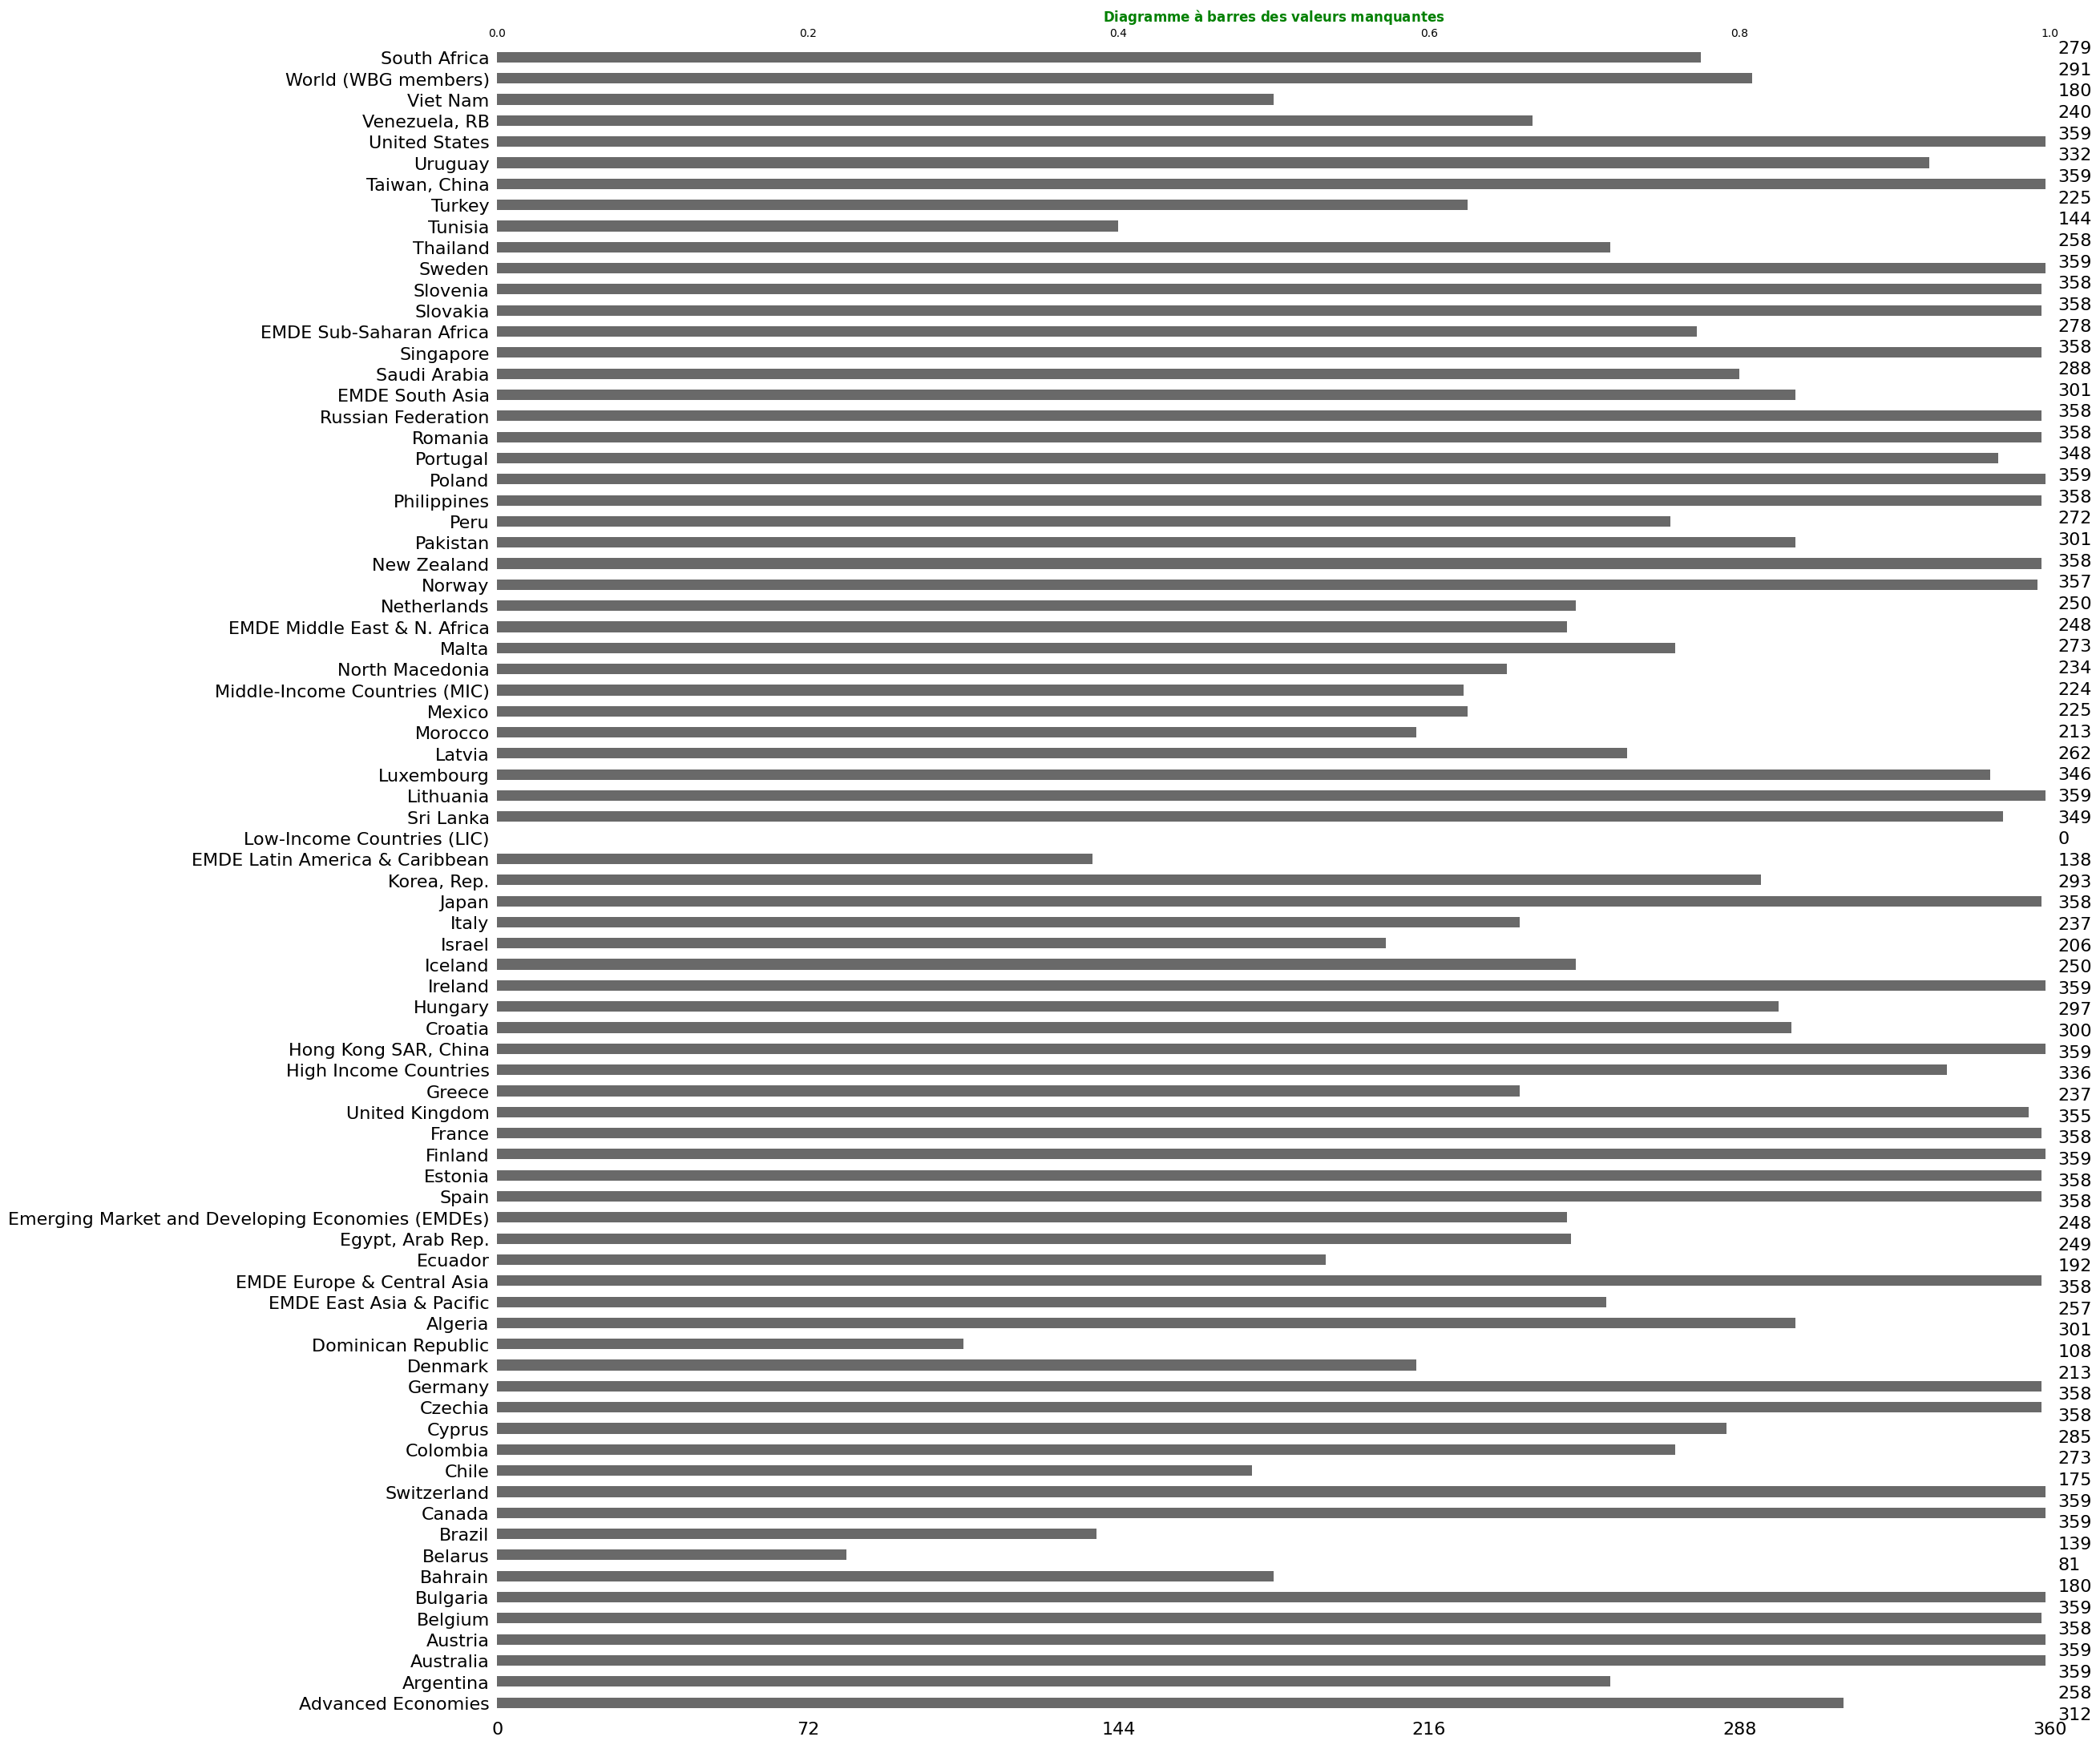

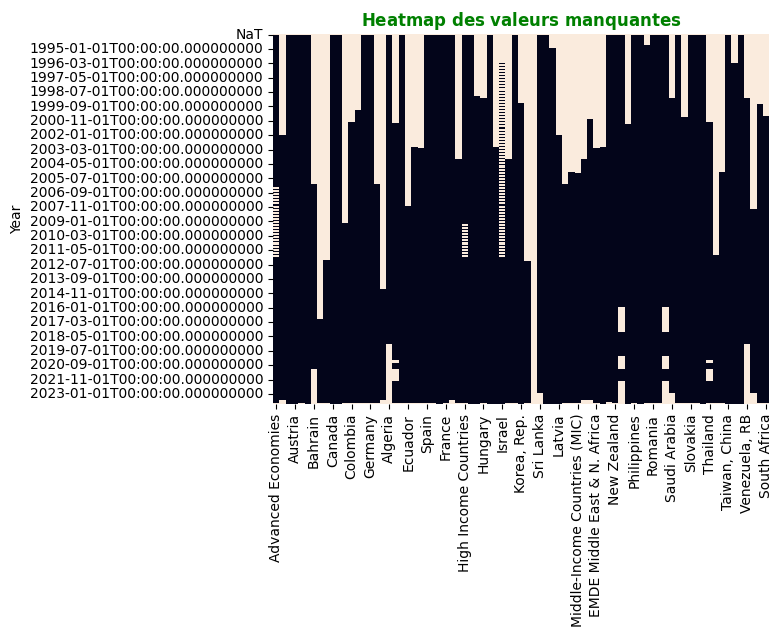

In [12]:
d.missing_plot(df_Unemployement)

Les données sont des séries temporelles.<br>
Grâce à la visualisation 2, on constate que pour la plupart des pays,<br>
les valeurs manquantes sont en début de periode d'obervation d'observation.<br>
Ainsi, nous allons garder les pays avec au moins 60% des observations non manquantes.

In [ ]:
# suppressions des pays avec au moins 40% des valeurs manquantes sur la période
d.missing(df_Unemployement)

#### Imputation des valeurs manquantes

In [ ]:
df_Unemployement.head()

In [ ]:
import pandas as pd
#df_it=d.pd.DataFrame(df_Unemployement['Italy'])
df_it=df_Unemployement[['Italy']]
print(df_it.head())
print(df_it.columns)
import pandas as pd

def remplir_valeurs_manquantes_par_mediane(df, fenetre_rolling=8):
    # Parcourir chaque colonne du DataFrame
    for col in df.columns:
        # Utiliser rolling pour calculer la médiane sur une fenêtre définie
        # Calculer la médiane des fenetre_rolling observations suivantes en excluant les valeurs manquantes
        df[col] = df[col].rolling(window=fenetre_rolling, min_periods=1).apply(lambda x: d.np.median(x.dropna()))
    return df

import pandas as pd

def fill_missing_with_median(df):
    # Itérer à travers chaque colonne du DataFrame
    for col in df.columns:
        # Itérer à travers chaque ligne du DataFrame
        for i in range(len(df)):
            # Vérifier si la valeur est manquante
            if pd.isnull(df.loc[i, col]):
                # Calculer la médiane des dix observations suivantes
                median_value = df.loc[i+1:i+20, col].median(skipna=True)
                # Remplacer la valeur manquante par la médiane calculée
                df.loc[i, col] = median_value
    
    return df

# Exemple d'utilisation
# Supposons que votre DataFrame s'appelle df
df_it_cor = fill_missing_with_median(df_it)


df_it_cor.head()

In [ ]:
d.missing_plot(df_it)
d.missing_plot(df_it_cor)

In [ ]:

## supression des deux premières lignes car nous allons commencer en 1994

df_Unemployement=df_Unemployement.drop([df_Unemployement.index[0], df_Unemployement.index[1]])


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Générer une série temporelle avec du bruit
np.random.seed(42)
n_obs = 100
epsilon = np.random.normal(size=n_obs)
y = np.zeros(n_obs)

for t in range(1, n_obs):
    y[t] = 0.7 * y[t-1] + epsilon[t]

# Afficher la série temporelle
plt.plot(y)
plt.title('Série temporelle avec du bruit')
plt.show()

# Ajuster un modèle ARMA(p, q)
p, q = 1, 1
model = sm.tsa.ARMA(y, order=(p, q))
results = model.fit()

# Afficher les résultats du modèle
print(results.summary())

# Prévoir les prochaines valeurs
forecast_steps = 10
forecast, stderr, conf_int = results.forecast(steps=forecast_steps)

# Afficher les prévisions
plt.plot(np.arange(n_obs), y, label='Observations')
plt.plot(np.arange(n_obs, n_obs + forecast_steps), forecast, label='Prévisions')
plt.fill_between(np.arange(n_obs, n_obs + forecast_steps), conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='Intervalle de confiance')
plt.title('Prévisions avec un modèle ARMA')
plt.legend()
plt.show()


# I- Base de données "taux de chômage"

## 1. Importation de la BD

In [7]:
rate=pd.read_excel("C:/Users/yousr/Downloads/Projet_py/Unemployment Rate.xlsx", sheet_name='monthly' , index_col=0 )
rate.head(5)
rate.index = pd.to_datetime(rate.index,format='%YM%m')
rate.index =rate.index.strftime('%Y-%m')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/yousr/Downloads/Projet_py/Unemployment Rate.xlsx'

In [ ]:
# Noms des colonnes
col_names=rate.columns
print(col_names)

### a. Type de données

In [ ]:
# Type de données de chaque colonne 
datas_type= rate.dtypes
print(datas_type)  # Il s'agit de données de type float

### b. Doublons

In [ ]:
duplicates = rate[rate.duplicated()]
duplicates.head(5) # 0 doublons dans notre DF

### c. Erreurs de frappes pour la colonne index

In [ ]:
rate.index = pd.to_datetime(rate.index, errors='coerce')
errors = rate[rate.index.isnull()]
errors.head(10) # Pas d'erreurs #########################################################################################

## 2. Construction de DF

In [ ]:
# Garder uniquement les pays dans la DF : Méthode search_fuzzy de pycountry ###############################################################

def detect_countries(col_names):
    countries_detected = []
    
    for name in col_names:
        try:
            # Essayer de trouver le pays par son nom
            pays= pycountry.countries.search_fuzzy(name)[0]
            countries_detected.append(pays.name)
        except LookupError:
            # Ignorer les noms qui ne correspondent à aucun pays
            pass
    
    return countries_detected

# Liste des pays detectés

countries_detected = detect_countries(col_names)
print("Noms de pays détectés :", countries_detected)

# Longeur des listes : countries_detected et col_names
print(len(countries_detected))
print(len(col_names))

# Différence entre les deux listes pour obtenir les noms des colonnes ignorées par la fonction detect_countries
#L'objectif est de vérifier si des pays ont été omis par la fonction detect_countries

# Pays dans col_names et pas dans countries_detected
diff= list(set(col_names) - set(countries_detected))
print(diff) 

# Pays dans countries_detected et pas dans col_names
diff2= list(set(countries_detected)- set(col_names))
print(diff2)

countries_omitted =['Korea, Rep.', 'Taiwan, China', 'Hong Kong SAR, China', 'Czech Republic', 'Egypt, Arab Rep.', 'Venezuela, RB'] ####################""
concat = countries_detected + countries_omitted 

# Enfin, la liste finale des pays à retenir dans la DF
countries_detected =list(set(concat)- set(diff2))
print(countries_detected)

# La DF taux de chomage à retenir après avoir filtré les pays
rate_filter= rate[countries_detected]
rate_filter.columns

In [ ]:
# Pour faciliter la lecture de la DF, on remplace les noms des pays par leurs codes ISO correspondant

# Dictionnaire de correspondance entre noms complets des pays et leurs codes
corresp = {country.name: country.alpha_3 for country in pycountry.countries}

# Liste initiale des noms complets des colonnes
country = countries_detected
# Transformation des noms complets des colonnes en abréviations
country_codes = [corresp.get(pays, pays) for pays in country]

# Remplacement des noms des pays par leurs codes dans la merged
rate_filter.columns=country_codes
rate_filter.columns
rate_filter.head(5)

#Ordre alphabétique des colonnes 
rate_filter_sort= rate_filter.sort_index(axis=1)
rate_filter_sort.head(5)

### 2.1. Valeurs manquantes

#### a. Visualisation des NA

In [ ]:
# Visualisation des valeurs manquantes NA
import missingno as msno
# Diagramme à barres des valeurs manquantes
msno.bar(rate_filter_sort)
plt.show()

#### b. Pourcentage des NA

In [ ]:
# Calculer le pourcentage de valeurs manquantes dans chaque colonne
size = rate_filter_sort.shape
nan_sum = rate_filter_sort.isna().sum() # Total du nombre de NA par colonne
nan_percent = nan_sum.sort_values(ascending=True) * 100 / size[0]
print(nan_percent)

#### c. Seuil des NA

In [ ]:
# Récupérer les colonnes avec un pourcentage de valeurs manquantes supérieur à 40%
cols_to_drop = nan_percent[nan_percent > 40].index
print(cols_to_drop)

# Supprimer les colonnes de la DataFrame
rate_filter_sort.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
# Type de données de chaque colonne 
data_type = rate_filter_sort.dtypes
print(data_type) # Toutes les colonnes sont de type float64

#### d. Imputation des valeurs manquantes

In [ ]:
# Imputation des NA par une moyenne arithmétique simple
rate_no_na = rate_filter_sort.fillna(rate_filter_sort.mean())

### 2.2. Valeurs abérrantes

In [ ]:
# Les valeurs abérrantes 
plt.figure(figsize=(10, 6))
sns.boxplot(data=rate_no_na)
plt.title('Boîtes à moustaches des séries temporelles')
plt.show()

### 2.3. Regroupement

In [ ]:
rate_no_na.index = pd.to_datetime(rate_no_na.index, format='%Y-%m-%d')

# Grouper par année et vérifier si tous les mois sont présents
rate_12= rate_no_na.groupby(rate_no_na.index.year).filter(lambda x: len(x) == 12)
rate_12= pd.DataFrame(rate_12)
rate_12.head(5)

In [ ]:
# Transformer les données mensuelles en données trimestrielles
rate_quart = rate_12.resample('Q-JAN').mean()
#print(rate_quart)

In [ ]:
# Ignorer les jours dans l'index
rate_quart.index =rate_quart.index.strftime('%Y-%m')

## Output : Taux de chômage par trimestre pour chaque pays

In [ ]:
rate_quart.head(5) #56 pays 

# II- Base de données "PIB"

## 1. Importation 

In [ ]:
# Importation du fichier .xlsx
gdp=pd.read_excel("C:/Users/yousr/Downloads/Projet_py/GDP Deflator at Market Prices, LCU.xlsx",  sheet_name='quarterly', index_col=0)
gdp.head(5)
gdp.index = pd.to_datetime(gdp.index)
gdp.index =gdp.index.strftime('%Y-%m')

In [ ]:
# Noms des colonnes
col_names=gdp.columns
print(col_names)

### a. Type de données

In [ ]:
# Type de données de chaque colonne 
datas_type= gdp.dtypes
print(datas_type)  # Données de type float

### b. Doublons

In [ ]:
duplicates = gdp[gdp.duplicated()]
duplicates.head(5) # 0 doublons dans notre gdp_no_na

### c. Erreurs de frappes pour la colonne index

In [ ]:
gdp.index = pd.to_datetime(gdp.index, errors='coerce')
errors = gdp[gdp.index.isnull()]
print(errors) # Pas d'erreurs

## 2. Construction de la DF

In [ ]:
# Garder uniquement les pays dans la gdp_filter_sort : Méthode search_fuzzy de pycountry ###############################################################

def detect_countries(col_names):
    countries_detected = []
    
    for name in col_names:
        try:
            # Essayer de trouver le pays par son nom
            pays= pycountry.countries.search_fuzzy(name)[0]
            countries_detected.append(pays.name)
        except LookupError:
            # Ignorer les noms qui ne correspondent à aucun pays
            pass
    
    return countries_detected

# Liste des pays detectés

countries_detected = detect_countries(col_names)
print("Noms de pays détectés :", countries_detected)

# Longeur des listes : countries_detected et col_names
print(len(countries_detected))
print(len(col_names))

# Différence entre les deux listes pour obtenir les noms des colonnes ignorées par la fonction detect_countries
#L'objectif est de vérifier si des pays ont été omis par la fonction detect_countries

# Pays dans col_names et pas dans countries_detected
diff= list(set(col_names) - set(countries_detected))
print(diff) 

# Pays dans countries_detected et pas dans col_names
diff2= list(set(countries_detected)- set(col_names))
print(diff2)

countries_omitted =['Korea, Rep.', 'Czech Republic', 'Taiwan, China', 'Bolivia', 'Hong Kong SAR, China', 'Egypt, Arab Rep.'] ####################""
concat = countries_detected + countries_omitted 

# Enfin, la liste finale des pays à retenir dans la gdp_filter_sort
countries_detected =list(set(concat)- set(diff2))
print(countries_detected)

# La gdp_filter_sort taux de chomage à retenir
gdp_filter= gdp[countries_detected]
gdp_filter.columns


In [ ]:
# Pour faciliter la lecture de la gdp_filter_sort, on remplace les noms des pays par leurs codes ISO  correspondant

# Dictionnaire de correspondance entre noms complets des pays et leurs codes
corresp = {country.name: country.alpha_3 for country in pycountry.countries}

# Liste initiale des noms complets des colonnes
country = countries_detected
# Transformation des noms complets des colonnes en abréviations
country_codes = [corresp.get(pays, pays) for pays in country]

# Remplacement des noms des pays par leurs codes dans la gdp_filter_sort
gdp_filter.columns=country_codes
gdp_filter.columns
gdp_filter.head(5)

#Ordre alphabétique des colonnes 
gdp_filter_sort= gdp_filter.sort_index(axis=1)

In [ ]:
gdp_filter_sort.head(5)

In [ ]:
# Nombre de lignes d'une gdp_filter_sort
count_rows= len(gdp_filter_sort)
print(count_rows) #120 lignes soit 120 trimestres

### 2.1. Valeurs manquantes

#### a. Visualisation

In [ ]:
# Diagramme à barres des valeurs manquantes
msno.bar(gdp_filter_sort)
plt.show()

#### b. Pourcentage des NA

In [ ]:
# Calculer le taux de valeurs manquantes
size = gdp_filter_sort.shape
nan_values = gdp_filter_sort.isna().sum()
nan_percent = nan_values.sort_values(ascending=True) * 100 / size[0]
print(nan_percent)

#### c. Seuil des NA 

In [ ]:
# Récupérer les colonnes avec un pourcentage de valeurs manquantes supérieur à 40%
cols_to_drop = nan_percent[nan_percent > 40].index
print(cols_to_drop)

# Supprimer les colonnes de la DataFrame
gdp_filter_sort.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
# Convertir l'index en type date { Les données sont trimestrielles pour le PIB }
gdp_filter_sort.index = pd.to_datetime(gdp_filter_sort.index)

# Afficher le DataFrame
gdp_filter_sort.head(5)

### 2.2. Plot

In [ ]:
# Graphique de l'évolution du taux de croissance (PIB) par pays sur toute la période

plt.figure(figsize=(15, 8))

for col in gdp_filter_sort.columns:
    plt.plot(gdp_filter_sort.index, gdp_filter_sort[col], label=col, alpha=0.7)

# Ajouter des titres et une légende
plt.title('Séries temporelles pour chaque colonne de la DataFrame')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Faire pivoter les étiquettes de l'axe des x
plt.xticks(rotation=45, ha='right')

# Afficher le graphique
plt.tight_layout()
plt.show()


### 2.3. Imputation 

In [ ]:
# Imputation des valeurs manquantes NA par interpolation

# Interpolation linéaire :

# gdp_filter_sort.interpolate(method='linear', limit=None)

# Interpolation polynômiale d'ordre 3 :

# gdp_filter_sort.interpolate(method='polynomial', order=3, limit=None)
              
gdp_no_na = gdp_filter_sort.fillna(gdp_filter_sort.mean())

In [ ]:
# Ignorer les jours dans l'index
gdp_no_na.index =gdp_no_na.index.strftime('%Y-%m')

## Output : BD des taux de croissance par trimestre pour chaque pays

In [ ]:
gdp_no_na.head(5) #72 pays

### 2.4. Valeurs abérrantes 

In [ ]:
# Les valeurs abérrantes 
# plt.figure(figsize=(10, 6))
"""sns.boxplot(data=gdp_no_na)
plt.title('Boîtes à moustaches des séries temporelles')
plt.show()"""

In [ ]:
# Définir l'index en tant que date
gdp_no_na.index = pd.to_datetime(gdp_no_na.index, format='%Y-%m')

# Grouper par année et vérifier si tous les trimestres sont présents
gdp_no_na = gdp_no_na.groupby(gdp_no_na.index.year).filter(lambda x: len(x) == 4)
gdp_no_na = pd.DataFrame(gdp_no_na)
gdp_no_na.head(5)

## 3. Jointure 

On réalise une jointure entre la Df contenant les taux de chomage et celle contenant les PIB par trimestre des différents pays

In [ ]:
# S'assurer que l'index des deux tables est identique, ce dernier constitue notre clé de jointure
print(rate_quart.index)
print(gdp_no_na.index)
print(rate_quart.index.equals(gdp_no_na.index))

In [ ]:
# Fusionner les DataFrames sur l'index en utilisant une jointure interne (how='inner')
common_columns = rate_quart.columns.intersection(gdp_no_na.columns)
print(common_columns)
display(rate_quart.head(1))
display(gdp_no_na.head(1))

In [ ]:
# Pour garder uniquement les colonnes présentes dans les deux DF
merged= pd.merge(rate_quart[common_columns], gdp_no_na[common_columns], left_index=True, right_index=True, how='inner' )

### 3.1. Output : Jointure taux de chomage/PIB

In [ ]:
merged.head(5)

### 3.3. Exportation de la jointure taux de chomage/PIB

In [ ]:
# Exportation de la DF construite sous un fichier .xlsx
merged.to_excel("Jointure_chomage_pib.xlsx", index=True)

In [ ]:
# Le fichier .xlxs ainsi créee peut se lire normalement
data = pd.read_excel("Jointure_chomage_pib.xlsx")
data.head()

In [ ]:
#Exemple
merged2 = merged[['ARG_x', 'ARG_y']]
merged2.head()

### 3.3. Jointure entre taux de chomage et PIB moyen sur toute la période

In [ ]:
mean_rate = pd.DataFrame(rate_quart.mean(), columns=['Taux de chomage'])
mean_gdp = pd.DataFrame(gdp_no_na.mean(), columns=['PIB'])
merged_mean= pd.merge(mean_rate, mean_gdp, left_index=True, right_index=True, how='inner')

## Output 

In [ ]:
merged_mean.head(5)

# III- Education

## 1. Importation 

In [ ]:
educ=pd.read_excel("C:/Users/yousr/Downloads/Projet_py/BIg_data.xlsx", sheet_name='HNP_StatsData', header=1, index_col=0)
educ.head(5)
col_names=educ.columns
print(col_names)

# Life Expectancy

In [ ]:
masque = educ['Indicator Name'].str.contains('expectancy', case=False) & educ['Indicator Name'].str.contains('total', case=False)
# Appliquez le masque pour obtenir un nouveau DataFrame avec les lignes filtrées
educ_LE = educ[masque]

In [ ]:
# Filtrer les colonnes qui contiennent des années ou les noms des pays
cols_to_keep = educ_LE.columns[educ_LE.columns.str.contains(r'\d{4}|Indicator Name')]

# Créer un nouveau DataFrame avec les colonnes filtrées
educ_LE_col = educ_LE[cols_to_keep]
print(educ_LE_col)

In [ ]:
educ_LE_col = educ_LE_col.drop(columns="Indicator Name")
mean_LE = educ_LE_col.mean(axis=1)

In [ ]:
mean_LE =mean_LE.to_frame(name='Life Expectancy')

# Population growth rate

In [ ]:
masque1 = educ['Indicator Name'].str.contains('Population growth ', case=False)
educ_PGR = educ[masque1]

In [ ]:
# Filtrer les colonnes qui contiennent des années ou les noms des pays
cols_to_keep1 = educ_PGR.columns[educ_PGR.columns.str.contains(r'\d{4}|Indicator Name')]

# Créer un nouveau DataFrame avec les colonnes filtrées
educ_PGR_filter1 = educ_PGR[cols_to_keep1]
print(educ_PGR_filter1)

In [ ]:
unique = educ_PGR_filter1['Indicator Name'].unique()
print(unique)

# On souhaite garder que le taux de croissance de la population totale

# Par élimination successive
# On garde les lignes où il y a le taux de croissance du milieu hors que urbain
masque2 = educ_PGR_filter1['Indicator Name'].str.contains('urban', case=False)
masque2_inverse= ~masque2 # Récupérer les lignes qui ne vérifient pas le masque
educ_PGR_filter2 = educ_PGR_filter1[masque2_inverse]

# On garde les lignes où il y a le taux de croissance du milieu hors que rural
masque3 = educ_PGR_filter2['Indicator Name'].str.contains('rural', case=False)
masque3_inverse = ~masque3
educ_PGR_filter3 = educ_PGR_filter2[masque3_inverse]

In [ ]:
educ_PGR_filter3  = educ_PGR_filter3.drop(columns="Indicator Name")
mean_PGR = educ_PGR_filter3.mean(axis=1)

In [ ]:
mean_PGR=mean_PGR .to_frame(name='Life Expectancy')

# IV- GMD Inégalités

## 1.  Importation

In [ ]:
# Gini Mean Difference
gmd=pd.read_excel("C:/Users/yousr/Downloads/Projet_py/inequality GMD World Bank.xlsx",  sheet_name='data', index_col=0)
gmd.head(5)
col_names=gmd.columns
print(col_names)

## 2. Construction de la DF

### 2.1. Extraction des colonnes nécessaires

In [ ]:
# Base de données de l'indice Theil
theil = gmd.pivot(index='year', columns='countryname', values='index')
theil.head(5)

In [ ]:
# La moyenne de l'indice de theil sur toutes les périodes
mean_theil = theil.mean(axis=0) 

In [ ]:
# Base de données du taux d'urbanisation
urban = gmd.pivot(index='year', columns='countryname', values='sp_urb_totl_in_zs')
urban.head(5)

In [ ]:
# La moyenne du taux d'urbanisation sur toutes les périodes
mean_urban = urban.mean(axis=0)

In [ ]:
# Base de données du ratio de pauvreté
poverty = gmd.pivot(index='year', columns='countryname', values='si_pov_lmic')
poverty.head(5)

In [ ]:
# La moyenne du ratio de pauvreté sur toutes les périodes
mean_poverty = poverty.mean(axis=0)

In [ ]:
# Dans pandas, une Df à une colonne correspond à une série. On donne un nom à chaque série pour une éventuelle jointure
mean_poverty.name = 'Ratio de pauvreté'
mean_urban.name = "Taux urbanisation"
mean_theil.name = 'Theil'

## 2.2. Jointure 

In [ ]:
# Jointure entre df1 et df2 sur la colonne "countryname"
merged1 = pd.merge(mean_poverty, mean_urban, on='countryname', how='inner')
# Jointure entre le résultat précédent (merged_df) et df3 sur la colonne "countryname"
final_merged1 = pd.merge(merged1, mean_theil, on='countryname', how='inner')

In [ ]:
# Dans pandas, une Df à une colonne correspond à une série. On donne un nom à chaque série pour une éventuelle jointure
mean_LE.name = 'Espérance de vie'
mean_PGR.name = "Croissance démo"

In [ ]:
final_merged1.index.name = 'Country Name'  ####################################################################################
mean_LE.index.name = 'Country Name'
mean_PGR.index.name = 'Country Name'
merged_mean.index.name = 'Country Name'

In [ ]:
# Jointure entre df1 et df2 sur la colonne "countryname"
merged2 = pd.merge(final_merged1, mean_PGR, on='Country Name', how='inner')
# Jointure entre le résultat précédent (merged_df) et df3 sur la colonne "countryname"
merged3 = pd.merge(merged2, mean_LE, on='Country Name', how='inner')

# Transposé de merged3

In [ ]:
merged3_transpose = merged3.transpose()
col_names = merged3_transpose.columns
merged3_transpose.head(5)

# Code ISO des pays

In [ ]:
# Pour faciliter la lecture de la DF, on remplace les noms des pays par leurs codes ISO  correspondant

# Dictionnaire de correspondance entre noms complets des pays et leurs codes
corresp = {country.name: country.alpha_3 for country in pycountry.countries}

# Liste initiale des noms complets des colonnes
country = col_names
# Transformation des noms complets des colonnes en abréviations
country_codes = [corresp.get(pays, pays) for pays in country]

# Remplacement des noms des pays par leurs codes dans la merged
merged3_transpose.columns=country_codes
merged3_transpose.columns
merged3_transpose.head(5)

#Ordre alphabétique des colonnes 
merged3_transpose_sort= merged3_transpose.sort_index(axis=1)
merged3_transpose_sort.head(5)

In [ ]:
merged4=merged3_transpose.transpose()
merged4.index.name= 'Country Name'
merged4.head(5)

In [ ]:
final_merged= pd.merge(merged4, merged_mean, on='Country Name', how='inner')